<a href="https://colab.research.google.com/github/ianara01/Park-Sangjin/blob/master/%5B%EC%8B%A4%EC%8A%B5%5DChest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 [런타임] -> [런타임 다시시작]을 클릭한 다음, 아래 셀부터 코드를 실행

# 라이브러리 불러오기 및 초기 설정

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import os
import time
import copy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [ ]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 데이터 다운로드

원본 데이터 : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [ ]:
w = !unzip /content/drive/MyDrive/src/data/chest_xray.zip

In [ ]:
data_dir = './chest_xray/'

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# 분류 클래스 설정
classes = ['normal', 'pneumonia']

# 데이터 로더

In [ ]:
# transform 의 정의

data_transforms = {
    # 검증 데이터용: 정규화만을 실시
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    # 학습 데이터용: 정규화에 RandomHorizontalFlip 과 RandomErasing 을 추가로 실시
    'train' : transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
    ])
}

In [ ]:
# 학습 데이터셋

data_dir = './chest_xray/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [ ]:
print("Train set 개수 : ", len(dataloaders['train'].dataset))
print("Validatation set 개수 : ", len(dataloaders['val'].dataset))

Train set 개수 :  5216
Validatation set 개수 :  16


In [ ]:
print(image_datasets['train'].classes)

['NORMAL', 'PNEUMONIA']


In [ ]:
# 테스트 데이터셋

test_data = datasets.ImageFolder(test_dir, transform=data_transforms['val'])
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
print("Test set 개수 : ", len(test_loader.dataset))

Test set 개수 :  624


## 학습용 데이터 시각화

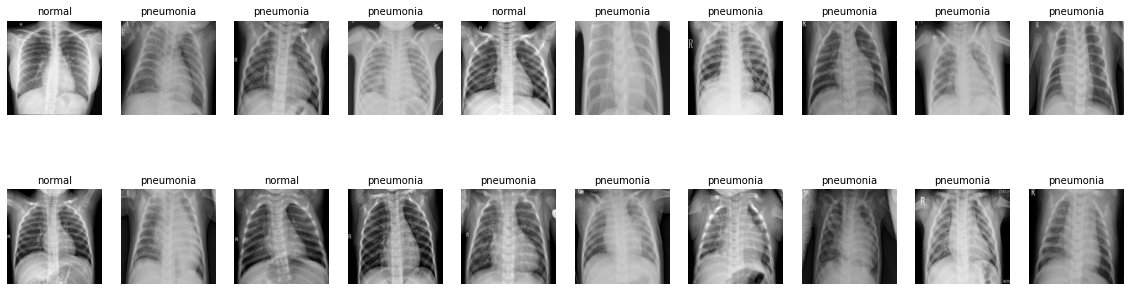

In [ ]:
# 학습용 데이터 (４0건)

plt.figure(figsize=(20, 15))

train_data2 = datasets.ImageFolder(train_dir, transform=data_transforms['val'])
train_loader2 = DataLoader(train_data2, batch_size=20, shuffle=True)


for images, labels in train_loader2:
  break

for i in range(len(images)):
    ax = plt.subplot(5, 10, i + 1)
    label_name = classes[labels[i]]
    ax.set_title(label_name, fontsize=10)
    # 텐서를 넘파이 배열로 변환
    image_np = images[i].numpy().copy()
    # 축의 순서 변경(channel, row, column) -> (row, column, channel)
    img = np.transpose(image_np, (1, 2, 0))
    # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
    img = (img + 1)/2
    # 결과 출력
    plt.imshow(img)
    ax.set_axis_off()
plt.show()

# 학습하기

## Scratch 모델 사용

### Load Model

In [ ]:
model_ft = models.resnet34(pretrained=False)

In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print(model_ft.fc)

num_ftrs = model_ft.fc.in_features
print(num_ftrs)

model_ft.fc = nn.Linear(num_ftrs, 2) ## 출력 노드 설정
print(model_ft.fc)

model_ft.to(device)

### Train

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase], 0)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


100%|██████████| 1044/1044 [01:47<00:00,  9.68it/s]


train Loss: 0.2175 Acc: 0.9195


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


val Loss: 0.6968 Acc: 0.6250

Epoch 1/4
----------


100%|██████████| 1044/1044 [01:38<00:00, 10.61it/s]


train Loss: 0.1406 Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  7.43it/s]


val Loss: 1.0018 Acc: 0.6875

Epoch 2/4
----------


100%|██████████| 1044/1044 [01:33<00:00, 11.17it/s]


train Loss: 0.1290 Acc: 0.9507


100%|██████████| 4/4 [00:00<00:00,  7.51it/s]


val Loss: 1.3279 Acc: 0.6250

Epoch 3/4
----------


100%|██████████| 1044/1044 [01:38<00:00, 10.64it/s]


train Loss: 0.1049 Acc: 0.9601


100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


val Loss: 0.7201 Acc: 0.6875

Epoch 4/4
----------


100%|██████████| 1044/1044 [01:33<00:00, 11.21it/s]


train Loss: 0.0798 Acc: 0.9737


100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

val Loss: 0.6783 Acc: 0.6875

Training complete in 8m 14s
Best val Acc: 0.687500


### Test 및 성능평가

In [ ]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = [] # 예측값
    y_true = [] # 실제값
    prob = [] # 모델 통과한 확률값
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted = predicted.data.cpu().detach().numpy()
        outputs = outputs.data.cpu().detach().numpy()
        labels = labels.data.cpu().detach().numpy()
        y_pred.extend(predicted)
        prob.extend(outputs)
        y_true.extend(labels)

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 79.6474358974359 %


Text(51.0, 0.5, 'True Label')

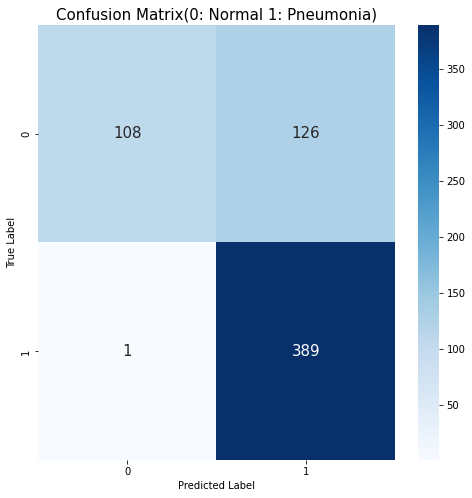

In [ ]:
## Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))    
plt.title('Confusion Matrix(0: Normal 1: Pneumonia)', fontdict={'fontsize':15})    
sns.heatmap(cm, annot=True, annot_kws={'size':15}, fmt='d', cmap='Blues')    
plt.xlabel('Predicted Label')    
plt.ylabel('True Label')

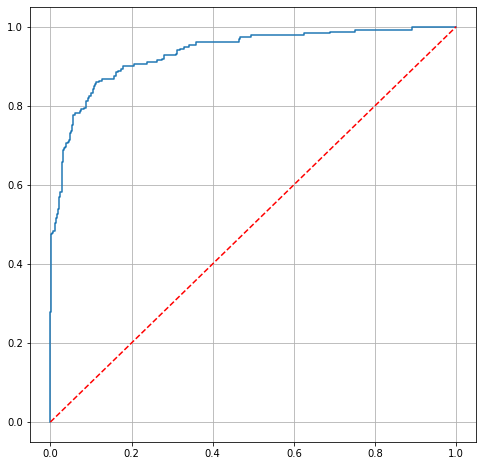

In [ ]:
## Roc Curve

from sklearn.metrics import roc_curve, roc_auc_score

prob1 = [p[0] for p in prob]
fpr, tpr, _ = roc_curve(y_true, prob1)


plt.figure(figsize=(8,8))
plt.plot(tpr, fpr, label=f'AUC - {np.round(1-roc_auc_score(y_true,prob1),3)}')
plt.plot((0,1),(0,1), color='red', linestyle='--')
plt.show()

In [ ]:
!pip install scikit-plot

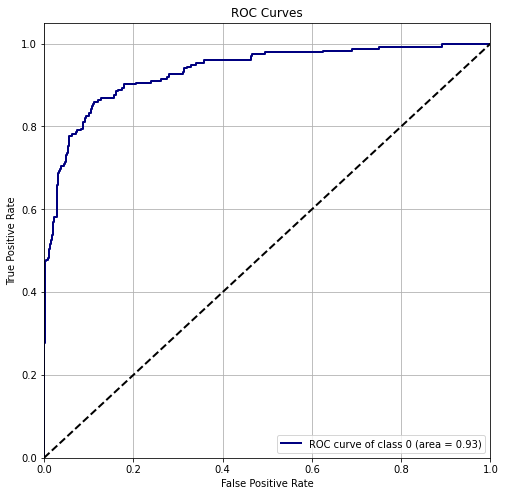

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_true, prob, plot_micro=False, plot_macro=False,
                           classes_to_plot=0,
                           figsize=(8,8),
                       cmap='jet')
plt.show()

## Pretrain 모델 사용

### Load Model

In [ ]:
model_ft = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model_ft

In [ ]:
print(model_ft.fc)

num_ftrs = model_ft.fc.in_features
print(num_ftrs)

model_ft.fc = nn.Linear(num_ftrs, 2) ## 출력 노드 설정
print(model_ft.fc)

model_ft.to(device)

Linear(in_features=512, out_features=1000, bias=True)
512
Linear(in_features=512, out_features=2, bias=True)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase], 0)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


100%|██████████| 1044/1044 [01:43<00:00, 10.04it/s]


train Loss: 0.1802 Acc: 0.9273


100%|██████████| 4/4 [00:00<00:00,  6.72it/s]


val Loss: 0.3914 Acc: 0.7500

Epoch 1/4
----------


100%|██████████| 1044/1044 [01:33<00:00, 11.21it/s]


train Loss: 0.1226 Acc: 0.9630


100%|██████████| 4/4 [00:00<00:00,  6.77it/s]


val Loss: 0.1372 Acc: 0.9375

Epoch 2/4
----------


100%|██████████| 1044/1044 [01:33<00:00, 11.22it/s]


train Loss: 0.0585 Acc: 0.9827


100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


val Loss: 0.3325 Acc: 0.8750

Epoch 3/4
----------


100%|██████████| 1044/1044 [01:32<00:00, 11.34it/s]


train Loss: 0.0469 Acc: 0.9833


100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


val Loss: 1.1126 Acc: 0.8125

Epoch 4/4
----------


100%|██████████| 1044/1044 [01:35<00:00, 10.95it/s]


train Loss: 0.0552 Acc: 0.9841


100%|██████████| 4/4 [00:00<00:00,  6.80it/s]

val Loss: 0.0210 Acc: 1.0000

Training complete in 8m 1s
Best val Acc: 1.000000


### Test 및 성능평가

In [ ]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = [] # 예측값
    y_true = [] # 실제값
    prob = [] # 모델 통과한 확률값
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted = predicted.data.cpu().detach().numpy()
        outputs = outputs.data.cpu().detach().numpy()
        labels = labels.data.cpu().detach().numpy()
        y_pred.extend(predicted)
        prob.extend(outputs)
        y_true.extend(labels)

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 79.6474358974359 %


Text(51.0, 0.5, 'True Label')

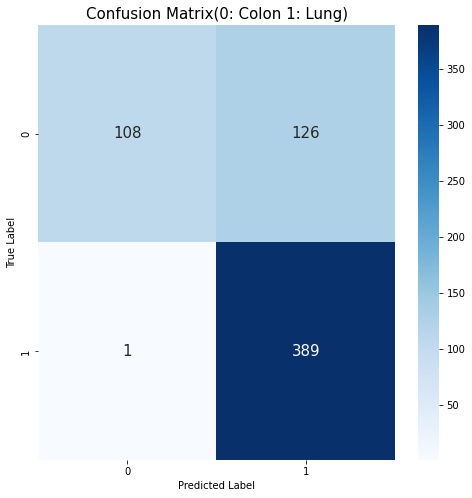

In [ ]:
## Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))    
plt.title('Confusion Matrix(0: Colon 1: Lung)', fontdict={'fontsize':15})    
sns.heatmap(cm, annot=True, annot_kws={'size':15}, fmt='d', cmap='Blues')    
plt.xlabel('Predicted Label')    
plt.ylabel('True Label')

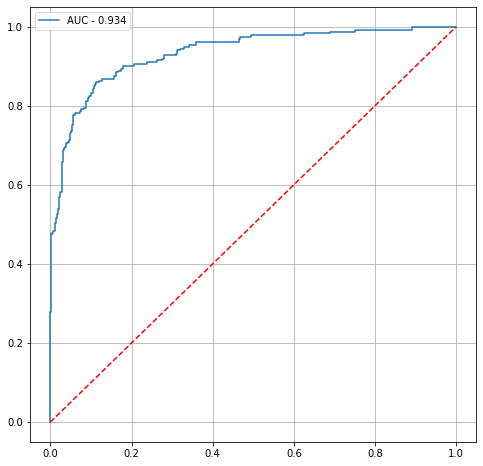

In [ ]:
## Roc Curve

from sklearn.metrics import roc_curve, roc_auc_score

prob1 = [p[0] for p in prob]
fpr, tpr, _ = roc_curve(y_true, prob1)


plt.figure(figsize=(8,8))
plt.plot(tpr, fpr, label=f'AUC - {np.round(1-roc_auc_score(y_true,prob1),3)}')
plt.plot((0,1),(0,1), color='red', linestyle='--')
plt.legend()
plt.show()

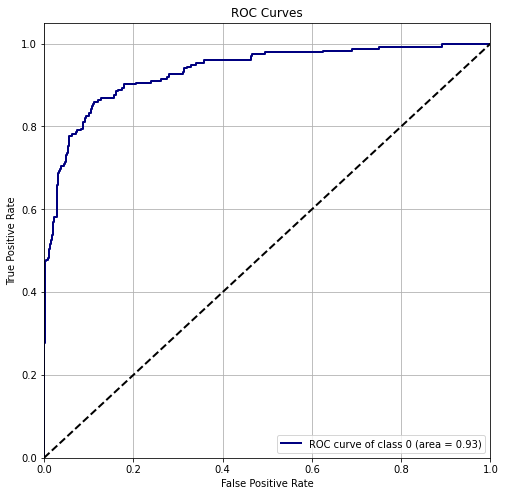

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_true, prob, plot_micro=False, plot_macro=False,
                           classes_to_plot=0,
                           figsize=(8,8),
                       cmap='jet')
plt.show()